# BEA: Tapping Detection Model Training
This notebook trains a CNN-LSTM model to detect hand tapping behavior in video clips for ADHD behavioral analysis using Raspberry Pi-compatible PyTorch code.

In [ ]:
# Install dependencies (only run once)
%pip install torch torchvision opencv-python numpy matplotlib

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import cv2
import numpy as np
from torchvision import transforms
from glob import glob
from tqdm import tqdm

# Settings
VIDEO_FRAMES = 16
IMAGE_SIZE = 64
BATCH_SIZE = 8
EPOCHS = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [3]:
# Custom Dataset
class TappingDataset(Dataset):
    def __init__(self, root_dir, label, transform):
        self.root_dir = root_dir
        self.videos = glob(os.path.join(root_dir, "*.mp4")) + glob(os.path.join(root_dir, "*.avi"))
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        frames = self._extract_frames(video_path)
        tensor = torch.stack([self.transform(f) for f in frames])
        return tensor, self.label

    def _extract_frames(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while len(frames) < VIDEO_FRAMES and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        while len(frames) < VIDEO_FRAMES:
            frames.append(frames[-1])
        return frames[:VIDEO_FRAMES]

In [4]:
# CNN-LSTM Model
class TapCNN(nn.Module):
    def __init__(self):
        super(TapCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.lstm = nn.LSTM(32 * 16 * 16, 64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(b * t, c, h, w)
        x = self.cnn(x)
        x = x.view(b, t, -1)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

In [10]:
# Load dataset
base = "tapping_hands"
train_data = [
    TappingDataset(os.path.join(base, "tapping/training"), 1, transform),
    TappingDataset(os.path.join(base, "non-tapping/training"), 0, transform)
]
test_data = [
    TappingDataset(os.path.join(base, "tapping/testing"), 1, transform),
    TappingDataset(os.path.join(base, "non-tapping/testing"), 0, transform)
]

# Debug: file counts
print("Tapping train:", len(train_data[0]))
print("Non-tapping train:", len(train_data[1]))
print("Tapping test:", len(test_data[0]))
print("Non-tapping test:", len(test_data[1]))

# Combine datasets
train_dataset = ConcatDataset(train_data)
test_dataset = ConcatDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Tapping train: 130
Non-tapping train: 130
Tapping test: 32
Non-tapping test: 32


In [12]:
# Training loop with accuracy tracking
model = TapCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch 1/25:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/25: 100%|██████████| 33/33 [00:45<00:00,  1.38s/it]


Epoch 1/25, Loss: 10.8767, Accuracy: 88.85%


Epoch 2/25: 100%|██████████| 33/33 [00:43<00:00,  1.32s/it]


Epoch 2/25, Loss: 0.7139, Accuracy: 99.62%


Epoch 3/25: 100%|██████████| 33/33 [00:42<00:00,  1.28s/it]


Epoch 3/25, Loss: 0.3103, Accuracy: 100.00%


Epoch 4/25: 100%|██████████| 33/33 [00:43<00:00,  1.33s/it]


Epoch 4/25, Loss: 0.2316, Accuracy: 100.00%


Epoch 5/25: 100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


Epoch 5/25, Loss: 0.0978, Accuracy: 100.00%


Epoch 6/25: 100%|██████████| 33/33 [00:41<00:00,  1.27s/it]


Epoch 6/25, Loss: 0.0543, Accuracy: 100.00%


Epoch 7/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]


Epoch 7/25, Loss: 0.0402, Accuracy: 100.00%


Epoch 8/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]


Epoch 8/25, Loss: 0.0327, Accuracy: 100.00%


Epoch 9/25: 100%|██████████| 33/33 [00:46<00:00,  1.42s/it]


Epoch 9/25, Loss: 0.0264, Accuracy: 100.00%


Epoch 10/25: 100%|██████████| 33/33 [00:40<00:00,  1.23s/it]


Epoch 10/25, Loss: 0.0223, Accuracy: 100.00%


Epoch 11/25: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


Epoch 11/25, Loss: 0.0193, Accuracy: 100.00%


Epoch 12/25: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


Epoch 12/25, Loss: 0.0168, Accuracy: 100.00%


Epoch 13/25: 100%|██████████| 33/33 [00:40<00:00,  1.23s/it]


Epoch 13/25, Loss: 0.0148, Accuracy: 100.00%


Epoch 14/25: 100%|██████████| 33/33 [00:37<00:00,  1.12s/it]


Epoch 14/25, Loss: 0.0134, Accuracy: 100.00%


Epoch 15/25: 100%|██████████| 33/33 [00:45<00:00,  1.38s/it]


Epoch 15/25, Loss: 0.0118, Accuracy: 100.00%


Epoch 16/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]


Epoch 16/25, Loss: 0.0093, Accuracy: 100.00%


Epoch 17/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]


Epoch 17/25, Loss: 0.0083, Accuracy: 100.00%


Epoch 18/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]


Epoch 18/25, Loss: 0.0070, Accuracy: 100.00%


Epoch 19/25: 100%|██████████| 33/33 [00:42<00:00,  1.28s/it]


Epoch 19/25, Loss: 0.0065, Accuracy: 100.00%


Epoch 20/25: 100%|██████████| 33/33 [00:39<00:00,  1.21s/it]


Epoch 20/25, Loss: 0.0059, Accuracy: 100.00%


Epoch 21/25: 100%|██████████| 33/33 [00:39<00:00,  1.20s/it]


Epoch 21/25, Loss: 0.0054, Accuracy: 100.00%


Epoch 22/25: 100%|██████████| 33/33 [00:41<00:00,  1.24s/it]


Epoch 22/25, Loss: 0.0049, Accuracy: 100.00%


Epoch 23/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]


Epoch 23/25, Loss: 0.0045, Accuracy: 100.00%


Epoch 24/25: 100%|██████████| 33/33 [00:40<00:00,  1.24s/it]


Epoch 24/25, Loss: 0.0041, Accuracy: 100.00%


Epoch 25/25: 100%|██████████| 33/33 [00:40<00:00,  1.22s/it]

Epoch 25/25, Loss: 0.0037, Accuracy: 100.00%


In [13]:
# Save the model
torch.save(model.state_dict(), "tap_detection_model.pth")

Test Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

 Non-Tapping       1.00      1.00      1.00        32
     Tapping       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



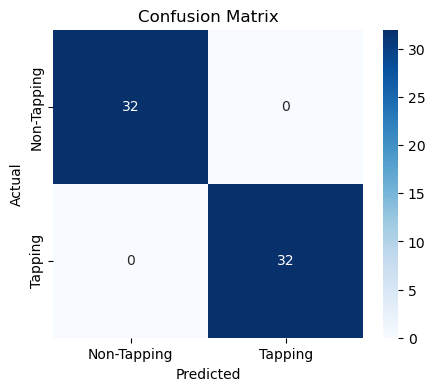

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Non-Tapping", "Tapping"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Non-Tapping", "Tapping"], yticklabels=["Non-Tapping", "Tapping"], cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import time
import cv2
import torch
from collections import deque
import numpy as np

# Load model
model = TapCNN().to(DEVICE)
model.load_state_dict(torch.load("tap_detection_model.pth", map_location=DEVICE))
model.eval()

# Video capture
cap = cv2.VideoCapture(0)
frame_queue = deque(maxlen=VIDEO_FRAMES)
counting_taps = 0
tapping_now = False
tap_cooldown = 0

# For motion detection
last_gray = None
motion_threshold = 500000  # adjust this if needed

def preprocess(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = transform(frame)
    return frame

print("Starting webcam. Press 'q' to exit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame is None:
        continue

    resized = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
    frame_queue.append(resized)

    # Motion detection setup
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    motion = False
    if last_gray is not None:
        frame_diff = cv2.absdiff(last_gray, gray)
        motion_score = np.sum(frame_diff)
        motion = motion_score > motion_threshold
    last_gray = gray

    if len(frame_queue) == VIDEO_FRAMES:
        with torch.no_grad():
            clip = torch.stack([preprocess(f) for f in frame_queue])
            clip = clip.unsqueeze(0).to(DEVICE)

            output = model(clip)
            probs = torch.softmax(output, dim=1)
            tap_prob = probs[0][1].item()
            _, pred = torch.max(output, 1)
            current_tap = int(pred.item())

            # ✅ Count tap only if tapping, high confidence, and movement
            if current_tap == 1 and tap_prob > 0.85 and not tapping_now and motion:
                counting_taps += 1
                tapping_now = True
                tap_cooldown = 10
                print(f"TAP DETECTED! Total: {counting_taps}")

            if tapping_now:
                tap_cooldown -= 1
                if tap_cooldown <= 0 or current_tap == 0 or tap_prob < 0.5:
                    tapping_now = False

            label = "TAPPING" if current_tap == 1 else "NOT TAPPING"
            color = (0, 255, 0) if current_tap == 1 else (0, 0, 255)
            cv2.putText(frame, f"{label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.putText(frame, f"Tap Count: {counting_taps}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.putText(frame, f"Tapping Prob: {tap_prob:.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv2.imshow("Tapping Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print(f"Final Tap Count: {counting_taps}")